# Ridge regression

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [4]:
model_name = "ridge"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(aml_dir + 'nyc_demand_train.csv', parse_dates=['timeStamp'])

Create model pipeline:
- one-hot encode categorical variables
- grid search to find optimal values for the alpha parameter 

In [6]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [7]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
tscv = TimeSeriesSplit(n_splits=3)

In [9]:
param_grid = {'alpha': [ 1e-4, 1e-3, 1e-2, 0.1, 1.0]}
regr_cv = GridSearchCV(estimator=regr,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.9s finished


Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('regr_cv', GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   ...*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2))])

Save model to AML shared directory

In [10]:
with open(aml_dir + model_name + '.pkl', 'wb') as f:
    pickle.dump(regr_pipe, f)

### Cross validation results

In [12]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,0.094166,0.003834,-3768.417051,-3706.083209,1,{'alpha': 1.0},1,-4083.317668,-3543.146328,-3759.650950,-3708.349953,-3462.282535,-3866.753345,0.011722,0.000472,253.612293,132.121734
3,0.171167,0.011501,-3768.671709,-3706.048894,0.1,{'alpha': 0.1},2,-4082.758792,-3543.121862,-3760.114244,-3708.308567,-3463.142092,-3866.716253,0.020102,0.003534,253.029822,132.116519
2,0.169672,0.007000,-3768.702300,-3706.048524,0.01,{'alpha': 0.01},3,-4082.703953,-3543.121604,-3760.169839,-3708.308115,-3463.233107,-3866.715852,0.037257,0.001081,252.969872,132.116460
1,0.222572,0.020668,-3768.705414,-3706.048520,0.001,{'alpha': 0.001},4,-4082.698480,-3543.121601,-3760.175500,-3708.308111,-3463.242263,-3866.715848,0.077435,0.005390,252.963859,132.116460
0,0.151074,0.005830,-3768.705726,-3706.048520,0.0001,{'alpha': 0.0001},5,-4082.697933,-3543.121601,-3760.176067,-3708.308111,-3463.243179,-3866.715848,0.063436,0.001837,252.963257,132.116460


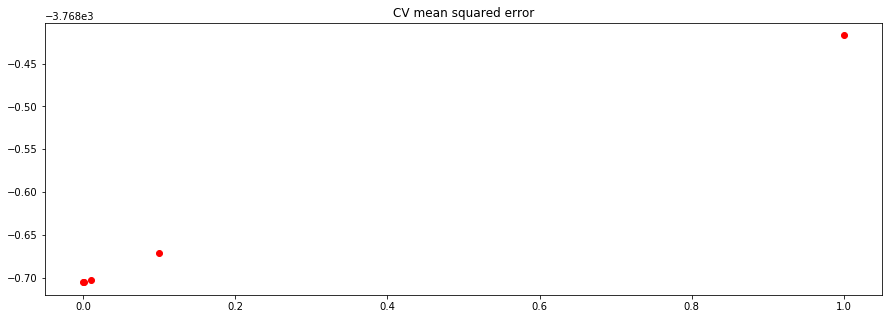

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro')
plt.title('CV mean squared error')
plt.show()